<a href="https://colab.research.google.com/github/ChardyBalla/Chardy/blob/main/Copy_of_M5_7_5_Cohort_Analysis_Homework_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cohort Analysis with Python

In [147]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Cohort Analysis on Holiday Shoppers

In the previous exercise, we performed cohort analysis and noticed that customers tend to purchase seasonally (end of the year holidays). Let's dive deeper to customers who first purchased on December 2009 and create cohorts based on number of transactions.

1. Load and clean the online retail dataset. Describe your key considerations and assumptions.
2. Create cohorts using customers with first purchase on December 2009. Group them by transaction count and generate a retention matrix. (Hint: group by customer id and [rank](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rank.html) with ascending invoice date)
3. Share your insights and observations on the resulting matrix. What recommendations would you give to boost re-purchases? (Hint: For easier visualization, plot a few transactions at a time (i.e. First 20 rows in 1 plot, Last 20 rows in another)).

## Data Summary


We are given an [online retail](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II) dataset containing transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

We are tasked to determine cohorts based on user retention and to provide insights and recommendations to improve customer loyalty.

Our data contains the following columns:

1. **InvoiceNo**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'C', it indicates a cancellation.
2. **StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
3. **Description**: Product (item) name. Nominal.
4. **Quantity**: The quantities of each product (item) per transaction. Numeric.
5. **InvoiceDate**: Invoice date and time. Numeric. The day and time when a transaction was generated.
6. **UnitPrice**: Unit price. Numeric. Product price per unit in sterling (Â£).
7. **CustomerID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
8. **Country**: Country name. Nominal. The name of the country where a customer resides.

# 1. Load and clean the online retail dataset.

**Note:** There are two files provided where one is an Excel `.xlsx` file while the other is a `.csv` file. You may use one of them and use the appropriate `pd` command to load them (either `read_excel()` or `read_csv()`)

For CSV
```python
df = pd.read_csv('online_retail.csv',
                 dtype={'Invoice':str, 'Customer ID':str},
                 parse_dates=['InvoiceDate'])
```

In [149]:
# We set Invoice and Customer ID as string types since they are the keys/ID for our dataset.
df = pd.read_excel('/content/drive/MyDrive/Refocus Module/Jupyter Notebook-20230501T012835Z-001/Jupyter Notebook/datasets/online_retail.xlsx',
                   dtype={'Invoice':str, 'Customer ID':str},
                   parse_dates=['InvoiceDate'])
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [151]:
# we are only interested in customers who first purchased on December 2009
# get list of customers first
customers = df.loc[df.InvoiceDate < datetime.datetime(2010,1,1), 'Customer ID'].unique()

In [152]:
first_purchase_date = datetime.datetime(2009, 12, 1)
last_purchase_date = datetime.datetime(2009, 12, 31)

customers = df[(df['InvoiceDate'] >= first_purchase_date) & (df['InvoiceDate'] <= last_purchase_date)]['Customer ID'].unique()


In [153]:
# filter the transactions
df = df[df['Customer ID'].isin(customers)]

In [154]:
# remove cancellations (Invoices Starts with C)
df = df[~df['Invoice'].str.startswith('C')]

In [155]:
# remove null customer IDs
df = df.dropna(subset=['Customer ID'])


In [156]:
# Add new columns to extract the year and the month
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month


In [157]:
df_monthly = df.groupby(['Year', 'Month'])['Invoice'].nunique()

# 2. Create cohorts using customers with first purchase on December 2009. Group them by transaction count and generate a retention matrix.

In [158]:
# remove duplicates
df_cohorts = df[['Customer ID', 'Invoice', 'InvoiceDate']].drop_duplicates()


In [159]:
# all first transaction month is December 2009
df_cohorts['first_txn'] = datetime.datetime(2009, 12, 1)
# convert to year-month
df_cohorts['first_txn'] = df_cohorts['first_txn'].dt.to_period('M')

In [160]:
# Add column for transaction count
# group by Customer ID and rank by ascending InvoiceDate
df_cohorts['txn_count'] = df_cohorts.groupby ('Customer ID')['InvoiceDate'].rank(method='first')

In [161]:
df_cohorts['txn_month'] = df_cohorts['InvoiceDate'].dt.to_period('M')

In [162]:
# Group by transaction count, transaction month, first transaction date
df_cohorts = df_cohorts.groupby(['txn_count', 'txn_month', 'first_txn'])['Customer ID'].nunique()
df_cohorts.name = 'num_customers'
df_cohorts = df_cohorts.reset_index()
df_cohorts.head(10)


,txn_count,txn_month,first_txn,num_customers
0,1.0,2009-12,2009-12,955
1,1.0,2010-01,2009-12,18
2,1.0,2010-02,2009-12,15
3,1.0,2010-03,2009-12,14
4,1.0,2010-04,2009-12,9
5,1.0,2010-05,2009-12,2
6,1.0,2010-06,2009-12,6
7,1.0,2010-07,2009-12,2
8,1.0,2010-08,2009-12,1
9,1.0,2010-09,2009-12,1


In [163]:
# subtract first_txn from txn_month, this will result in a MonthEnd pandas datatype
# to get the value as integer, we use the pandas apply function
df_cohorts['period_number'] = (df_cohorts['txn_month'] - df_cohorts['first_txn']).apply(lambda x: x.n)
df_cohorts.head(10)

,txn_count,txn_month,first_txn,num_customers,period_number
0,1.0,2009-12,2009-12,955,0
1,1.0,2010-01,2009-12,18,1
2,1.0,2010-02,2009-12,15,2
3,1.0,2010-03,2009-12,14,3
4,1.0,2010-04,2009-12,9,4
5,1.0,2010-05,2009-12,2,5
6,1.0,2010-06,2009-12,6,6
7,1.0,2010-07,2009-12,2,7
8,1.0,2010-08,2009-12,1,8
9,1.0,2010-09,2009-12,1,9


In [173]:
df_pivot = df_cohorts.pivot_table(index='txn_count', columns='period_number', values='num_customers')

In [174]:
# get the original cohort size - based on how many customers have a given txn_count
df_orig_cohorts = df_pivot.sum(axis=1)

In [175]:
# divide by original cohort size
df_pivot = df_pivot.divide(df_orig_cohorts, axis=0)
df_pivot


period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
txn_count,,,,,,,,,,,,,
1.0,0.929893,0.017527,0.014606,0.013632,0.008763,0.001947,0.005842,0.001947,0.000974,0.000974,0.001947,0.001947,NaN
2.0,0.313596,0.208333,0.099781,0.119518,0.058114,0.052632,0.039474,0.018640,0.017544,0.017544,0.028509,0.026316,NaN
3.0,0.142678,0.125156,0.146433,0.125156,0.117647,0.070088,0.055069,0.038798,0.030038,0.041302,0.046308,0.047559,0.013767
4.0,0.075691,0.091703,0.112082,0.147016,0.097525,0.082969,0.082969,0.066958,0.043668,0.049491,0.075691,0.062591,0.011645
5.0,0.050167,0.065217,0.093645,0.093645,0.112040,0.108696,0.098662,0.075251,0.055184,0.058528,0.065217,0.100334,0.023411
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


# 3. Share your insights and observations on the resulting matrix. What recommendations would you give to boost re-purchases?

You can create plots and visualizations using matplotlib pyplot `plt` or Seaborn `sns` to support your insights. You have creative freedom in presenting your insights.

import matplotlib
import numpy as np

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for _, spine in ax.spines.items():
      spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [172]:
import matplotlib
import numpy as np

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for _, spine in ax.spines.items():
      spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1311: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:374: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  return self.fmt.format(x=x, pos=pos)


Text(0.5, 0, 'Period')

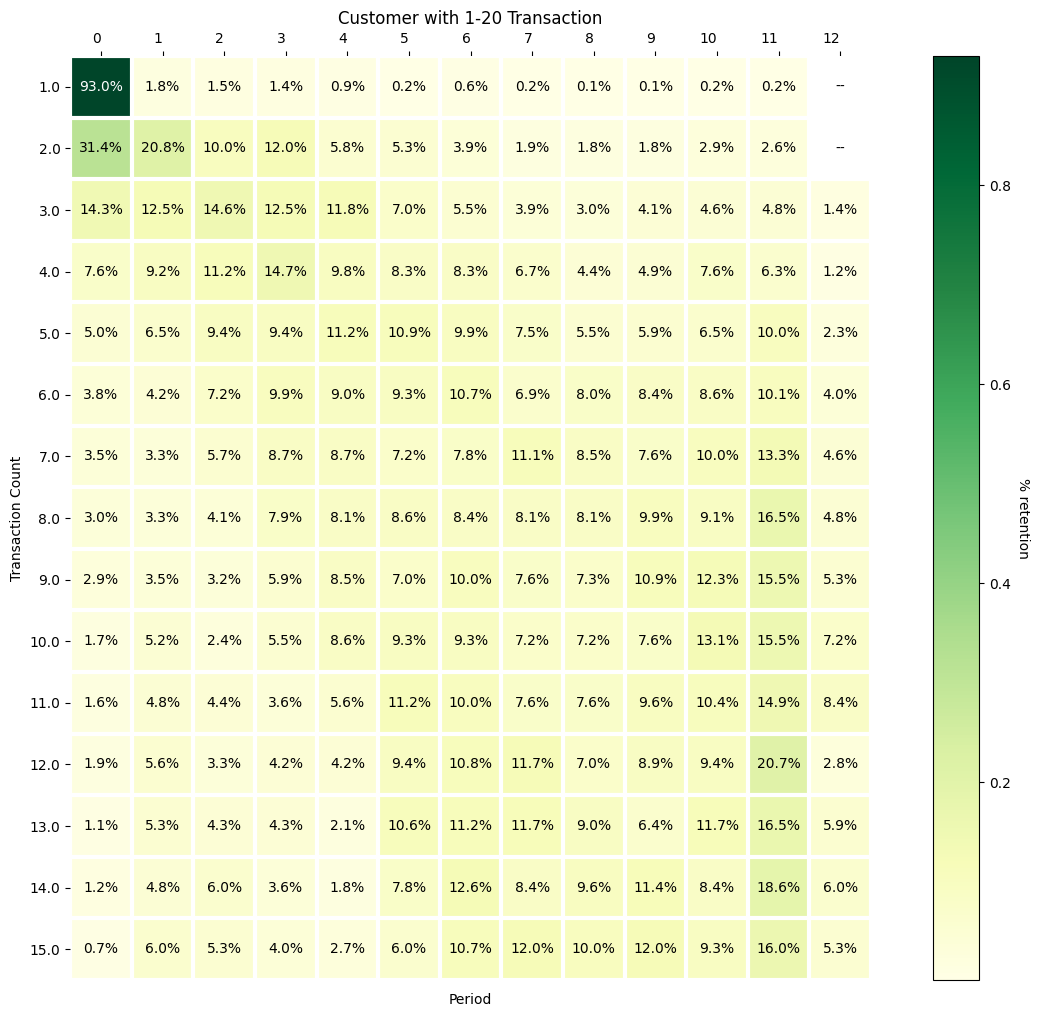

In [179]:
fig, ax = plt.subplots(figsize=(16,12))

df_top = df_pivot.head(15)

im, cbar = heatmap(df_top.values, df_top.index, df_top.columns, ax=ax,
			  cmap="YlGn", cbarlabel="% retention")

texts = annotate_heatmap(im, valfmt="{x:.1%}")

ax.set_title('Customer with 1-20 Transaction')
ax.set_ylabel('Transaction Count')
ax.set_xlabel('Period')

